In [1]:
# 라이브러리 설치
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import *
from sklearn.preprocessing import *
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import joblib
import tensorflow.keras.optimizers as optimizer
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM
from tensorflow.keras import regularizers

In [2]:
df0 = pd.read_csv("hand_data/0.csv", header=None)
print("Class 0 Shape", df0.shape)
df1 = pd.read_csv("hand_data/1.csv", header=None)
print("Class 0 Shape", df1.shape)
df2 = pd.read_csv("hand_data/2.csv", header=None)
print("Class 0 Shape", df2.shape)
df3 = pd.read_csv("hand_data/3.csv", header=None)
print("Class 0 Shape", df3.shape)

Class 0 Shape (2910, 65)
Class 0 Shape (2903, 65)
Class 0 Shape (2943, 65)
Class 0 Shape (2922, 65)


In [3]:
df = pd.concat([df0,df1,df2,df3])
data = df.values

print("Class df Shape", df.shape)
print(df.head())

Class df Shape (11678, 65)
     0    1    2    3     4     5      6     7     8    9   ...    55    56  \
0  26.0  4.0  5.0  8.0  -1.0 -13.0 -109.0 -66.0  -9.0  2.0  ... -28.0  61.0   
1 -47.0 -6.0 -5.0 -7.0  13.0  -1.0   35.0 -10.0  10.0 -4.0  ... -25.0  47.0   
2 -19.0 -8.0 -8.0 -8.0 -21.0  -6.0  -79.0  12.0   0.0  5.0  ... -83.0   7.0   
3   2.0  3.0  0.0  2.0   0.0  22.0  106.0 -14.0 -16.0 -2.0  ... -38.0 -11.0   
4   6.0  0.0  0.0 -2.0 -14.0  10.0  -51.0   5.0   7.0  0.0  ...  38.0 -35.0   

    57   58    59    60    61     62    63  64  
0  4.0  8.0   5.0   4.0  -7.0  -59.0  16.0   0  
1  6.0  6.0   5.0  13.0  21.0  111.0  15.0   0  
2  7.0  1.0  -8.0   7.0  21.0  114.0  48.0   0  
3  4.0  7.0  11.0  33.0  39.0  119.0  43.0   0  
4 -8.0  2.0   6.0 -13.0 -24.0 -112.0 -69.0   0  

[5 rows x 65 columns]


AxesSubplot(0.125,0.125;0.775x0.755)


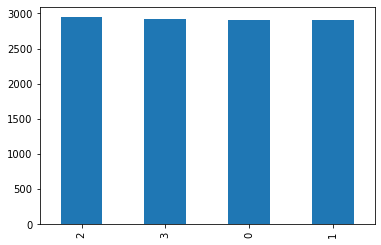

In [4]:
print(df[64].value_counts().plot(kind='bar'))

In [5]:
df = df.to_numpy()

X = df[:,0:64]
y = df[:,64:65]

print(X.shape)
print(y.shape)

(11678, 64)
(11678, 1)


In [6]:
X = np.where(X < 0, 0, X)

X = X.astype('float64')
y = y.astype('float64')

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, shuffle=True)        # train, test 분리

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(9342, 64)
(9342, 1)
(2336, 64)
(2336, 1)


In [7]:
# 데이터 가공
y_train2 = np.ravel(y_train)
y_test2 = np.ravel(y_test)

X_train1 = np.expand_dims(X_train, 2)
X_test1 = np.expand_dims(X_test, 2)
#X_train1 = np.hstack()

y_train1 = to_categorical(y_train)
y_test1 = to_categorical(y_test)

print(X_test1.shape)
print(X_train1.shape)
print(y_train2.shape)

(2336, 64, 1)
(9342, 64, 1)
(9342,)


In [8]:
# 모델 생성
model1 = Sequential()
model1.add(Embedding(15000, 2, input_length=64))
model1.add(Dropout(0.2))

#1
model1.add(Conv1D(filters=32, kernel_size=20, activation="relu", padding="same"))
model1.add(BatchNormalization())

#2
model1.add(Conv1D(filters=32, kernel_size=20, activation="relu", padding="valid"))
model1.add(BatchNormalization())
model1.add(SpatialDropout1D(0.5))

#3
model1.add(Conv1D(filters=32, kernel_size=6, activation="relu", padding="valid"))
model1.add(AveragePooling1D(pool_size=2))

#4
model1.add(Conv1D(filters=64, kernel_size=6, activation="relu", padding="valid"))
model1.add(SpatialDropout1D(0.5))

model1.add(Flatten())
model1.add(Dense(units=296, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(units=148, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(units=74, activation="relu"))
model1.add(Dropout(0.5))

model1.add(Dense(units=6, activation="softmax"))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 2)             30000     
                                                                 
 dropout (Dropout)           (None, 64, 2)             0         
                                                                 
 conv1d (Conv1D)             (None, 64, 32)            1312      
                                                                 
 batch_normalization (BatchN  (None, 64, 32)           128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 32)            20512     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 32)           128       
 hNormalization)                                        

In [9]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [10]:
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', patience=100, min_delta=0.001)
mc = ModelCheckpoint('best_model-1d_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [11]:
config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.compat.v1.Session(config=config)

In [12]:
h1 = model1.fit(X_train, y_train2,
                epochs = 1000,
                validation_data = (X_test1, y_test2),
                batch_size = 64,
                callbacks=[es, mc])

Epoch 1/1000
146/146 [==============================] - ETA: 0s - loss: 1.5587 - acc: 0.2379
Epoch 00001: val_acc improved from -inf to 0.26455, saving model to best_model-1d_cnn.h5
146/146 [==============================] - 13s 47ms/step - loss: 1.5587 - acc: 0.2379 - val_loss: 1.5648 - val_acc: 0.2646
Epoch 2/1000
145/146 [============================>.] - ETA: 0s - loss: 1.4292 - acc: 0.2553
Epoch 00002: val_acc did not improve from 0.26455
146/146 [==============================] - 4s 29ms/step - loss: 1.4292 - acc: 0.2553 - val_loss: 1.4449 - val_acc: 0.2397
Epoch 3/1000
145/146 [============================>.] - ETA: 0s - loss: 1.4089 - acc: 0.2607
Epoch 00003: val_acc did not improve from 0.26455
146/146 [==============================] - 4s 29ms/step - loss: 1.4089 - acc: 0.2602 - val_loss: 1.4068 - val_acc: 0.2453
Epoch 4/1000
145/146 [============================>.] - ETA: 0s - loss: 1.4006 - acc: 0.2477
Epoch 00004: val_acc did not improve from 0.26455
146/146 [=============

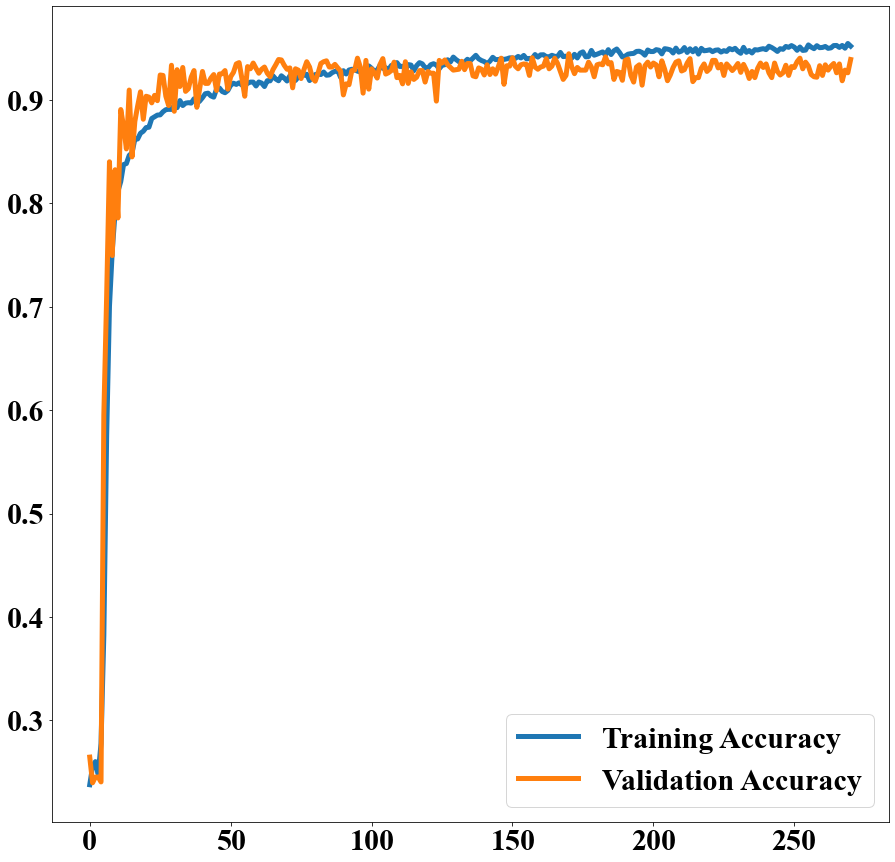

In [14]:
from tkinter import font


acc = h1.history['acc']
val_acc = h1.history['val_acc']

loss=h1.history['loss']
val_loss=h1.history['val_loss']

epochs_range = range(271)

plt.figure(figsize=(15,15))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

plt.plot(epochs_range, acc, label='Training Accuracy', linewidth = 5)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth = 5)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.legend(loc='lower right', fontsize = 30)
#plt.title('Training and Validation Accuracy', fontsize = 20)


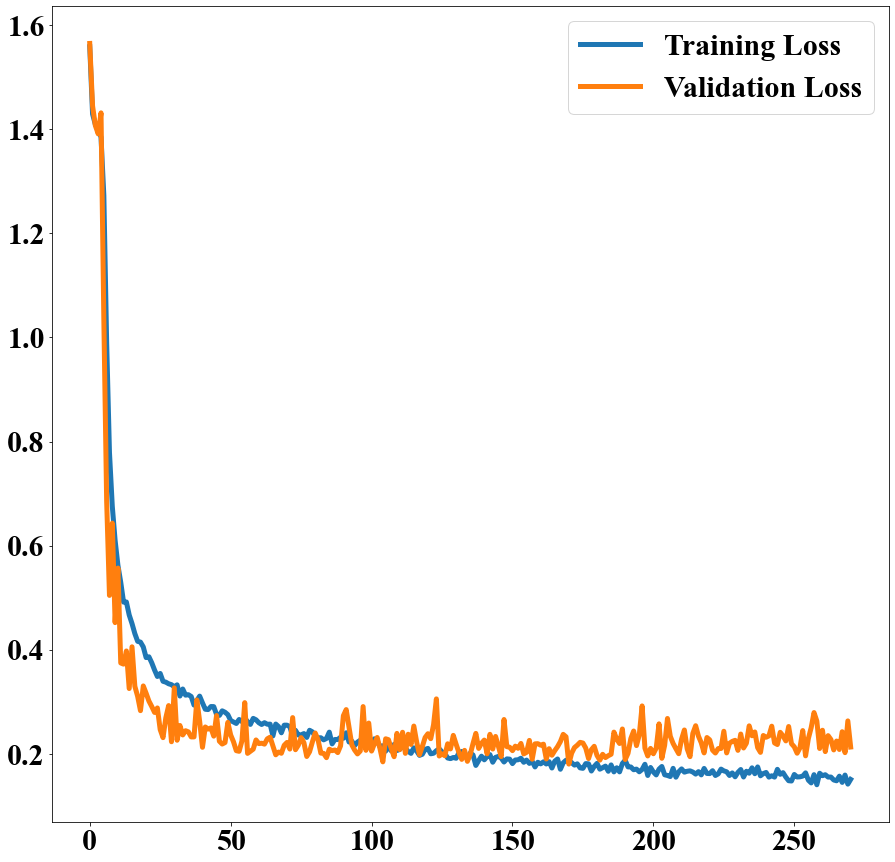

In [15]:
plt.figure(figsize=(15,15))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'

plt.plot(epochs_range, loss, label='Training Loss', linewidth = 5)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth = 5)

plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(loc='upper right', fontsize = 30)


#plt.title('Training and Validation Loss', fontsize = 20)
plt.show()